## 1. Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
fraud_file_path = 'root/Dataset/Fraud.csv'
#credit_file_path = 'C:/AIT/FirstSem/ML/ML_Project/Developing/Dataset/creditcard_2023.csv'

In [3]:
# pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
df_org    = pd.read_csv(fraud_file_path,sep=',')
df_org.shape

(6362620, 11)

In [5]:
df = df_org.copy()

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 2. Divided into batched

In [7]:
df_fraud_no  = df[df['isFraud']==0]
df_fraud_yes = df[df['isFraud']==1]
df_fraud_no.shape, df_fraud_yes.shape

((6354407, 11), (8213, 11))

In [8]:
df_fraud_no.isna().sum(), df_fraud_yes.isna().sum()

(step              0
 type              0
 amount            0
 nameOrig          0
 oldbalanceOrg     0
 newbalanceOrig    0
 nameDest          0
 oldbalanceDest    0
 newbalanceDest    0
 isFraud           0
 isFlaggedFraud    0
 dtype: int64,
 step              0
 type              0
 amount            0
 nameOrig          0
 oldbalanceOrg     0
 newbalanceOrig    0
 nameDest          0
 oldbalanceDest    0
 newbalanceDest    0
 isFraud           0
 isFlaggedFraud    0
 dtype: int64)

In [9]:
batch_size    = 1000000
total_samples = df_fraud_no.shape[0]
total_samples

6354407

In [10]:
num_batches = (total_samples // batch_size) + 1
num_batches

7

In [11]:
sampled_batches = []
df_fraud_no_copy = df_fraud_no.copy()
df_fraud_no_copy.shape

(6354407, 11)

In [12]:
for i in range(num_batches):
    # Check if there are enough rows remaining for a full batch
    if len(df_fraud_no_copy) >= batch_size:
        batch = df_fraud_no_copy.sample(n=batch_size, replace=False)
        sampled_batches.append(batch)
        df_fraud_no_copy = df_fraud_no_copy.drop(batch.index)  # Remove the sampled rows from the original DataFrame
    else:
        sampled_batches.append(df_fraud_no_copy)

In [13]:
sampled_batches[6].shape, df_fraud_no_copy.shape, df_fraud_no.shape, df_fraud_yes.shape

((354407, 11), (354407, 11), (6354407, 11), (8213, 11))

## 3. Exploratory Data Analysis

In [14]:
def encode_type(df, col_name):
    onehot = OneHotEncoder(sparse_output=False)
    trans_type = onehot.fit_transform(df[[col_name]])
    columns_trans_type = onehot.get_feature_names_out()
    trans_type_df = pd.DataFrame(trans_type,columns=columns_trans_type)
    encoded_df = pd.concat([df, trans_type_df], axis=1).drop(columns=col_name)
    return encoded_df

In [15]:
blacklist_path = 'root/Dataset/blacklist.xlsx'
whitelist_path = 'root/Dataset/whitelist.xlsx'

blacklist = pd.read_excel(blacklist_path,sheet_name='Sheet1')
whitelist = pd.read_excel(whitelist_path,sheet_name='Sheet1')

In [16]:
def check_blacklist(df):
    df['blacklist_flag_org'] = 0
    df['blacklist_flag_dest'] = 0

    for index, row in df.iterrows():
        if row['nameOrig'] in blacklist['blacklist_name'].values:
            df.at[index, 'blacklist_flag_org'] = 1
        
        if row['nameDest'] in blacklist['blacklist_name'].values:
            df.at[index, 'blacklist_flag_dest'] = 1
    return df

### 3.1 Batch-1

In [17]:
df_batch = sampled_batches[0]

In [18]:
df = pd.concat([df_batch,df_fraud_yes],axis=0, ignore_index=True)
df.shape

(1008213, 11)

In [19]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,282,TRANSFER,464600.35,C469131495,11028.00,0.00,C342883661,35315.32,499915.66,0,0
1,212,PAYMENT,2517.63,C1525615562,106528.89,104011.26,M600929596,0.00,0.00,0,0
2,235,CASH_OUT,57789.09,C1551452782,5555.00,0.00,C1662050128,0.00,57789.09,0,0
3,371,PAYMENT,7698.26,C1776033547,0.00,0.00,M1370947243,0.00,0.00,0,0
4,350,CASH_IN,129727.76,C1741301290,10331.00,140058.76,C1909391927,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1008208,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
1008209,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
1008210,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
1008211,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [20]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [21]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,282,TRANSFER,464600.35,C469131495,11028.00,0.00,C342883661,35315.32,499915.66,0,0
1,212,PAYMENT,2517.63,C1525615562,106528.89,104011.26,M600929596,0.00,0.00,0,0
2,235,CASH_OUT,57789.09,C1551452782,5555.00,0.00,C1662050128,0.00,57789.09,0,0
3,371,PAYMENT,7698.26,C1776033547,0.00,0.00,M1370947243,0.00,0.00,0,0
4,350,CASH_IN,129727.76,C1741301290,10331.00,140058.76,C1909391927,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1008208,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
1008209,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
1008210,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
1008211,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [22]:
df = encode_type(df,'type')
df.shape

(1008213, 15)

In [23]:
df.isna().sum()

step              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
type_CASH_IN      0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64

In [24]:
df = check_blacklist(df)
df.shape

(1008213, 17)

In [25]:
df.isna().sum()

step                   0
amount                 0
nameOrig               0
oldbalanceOrg          0
newbalanceOrig         0
nameDest               0
oldbalanceDest         0
newbalanceDest         0
isFraud                0
isFlaggedFraud         0
type_CASH_IN           0
type_CASH_OUT          0
type_DEBIT             0
type_PAYMENT           0
type_TRANSFER          0
blacklist_flag_org     0
blacklist_flag_dest    0
dtype: int64

In [26]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,blacklist_flag_org,blacklist_flag_dest
0,282,464600.35,C469131495,11028.00,0.00,C342883661,35315.32,499915.66,0,0,0.0,0.0,0.0,0.0,1.0,0,0
1,212,2517.63,C1525615562,106528.89,104011.26,M600929596,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0,0,0
2,235,57789.09,C1551452782,5555.00,0.00,C1662050128,0.00,57789.09,0,0,0.0,1.0,0.0,0.0,0.0,0,0
3,371,7698.26,C1776033547,0.00,0.00,M1370947243,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0,0,0
4,350,129727.76,C1741301290,10331.00,140058.76,C1909391927,0.00,0.00,0,0,1.0,0.0,0.0,0.0,0.0,0,0


In [27]:
df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,blacklist_flag_org,blacklist_flag_dest
0,282,464600.35,C469131495,11028.00,0.00,C342883661,35315.32,499915.66,0,0,0.0,0.0,0.0,0.0,1.0,0,0
1,212,2517.63,C1525615562,106528.89,104011.26,M600929596,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0,0,0
2,235,57789.09,C1551452782,5555.00,0.00,C1662050128,0.00,57789.09,0,0,0.0,1.0,0.0,0.0,0.0,0,0
3,371,7698.26,C1776033547,0.00,0.00,M1370947243,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0,0,0
4,350,129727.76,C1741301290,10331.00,140058.76,C1909391927,0.00,0.00,0,0,1.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008208,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0.0,1.0,0.0,0.0,0.0,0,0
1008209,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0,0,0
1008210,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0.0,1.0,0.0,0.0,0.0,0,0
1008211,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0,0,0


In [28]:
df[df['blacklist_flag_org']== 1] 

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,blacklist_flag_org,blacklist_flag_dest
1002377,212,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1.0,1,1
1002839,250,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1.0,1,0
1003167,279,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1,0.0,0.0,0.0,0.0,1.0,1,0


In [29]:
df.dtypes

step                     int64
amount                 float64
nameOrig                object
oldbalanceOrg          float64
newbalanceOrig         float64
nameDest                object
oldbalanceDest         float64
newbalanceDest         float64
isFraud                  int64
isFlaggedFraud           int64
type_CASH_IN           float64
type_CASH_OUT          float64
type_DEBIT             float64
type_PAYMENT           float64
type_TRANSFER          float64
blacklist_flag_org       int64
blacklist_flag_dest      int64
dtype: object

/tmp/ipykernel_22672/1437744229.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm")


<Axes: >

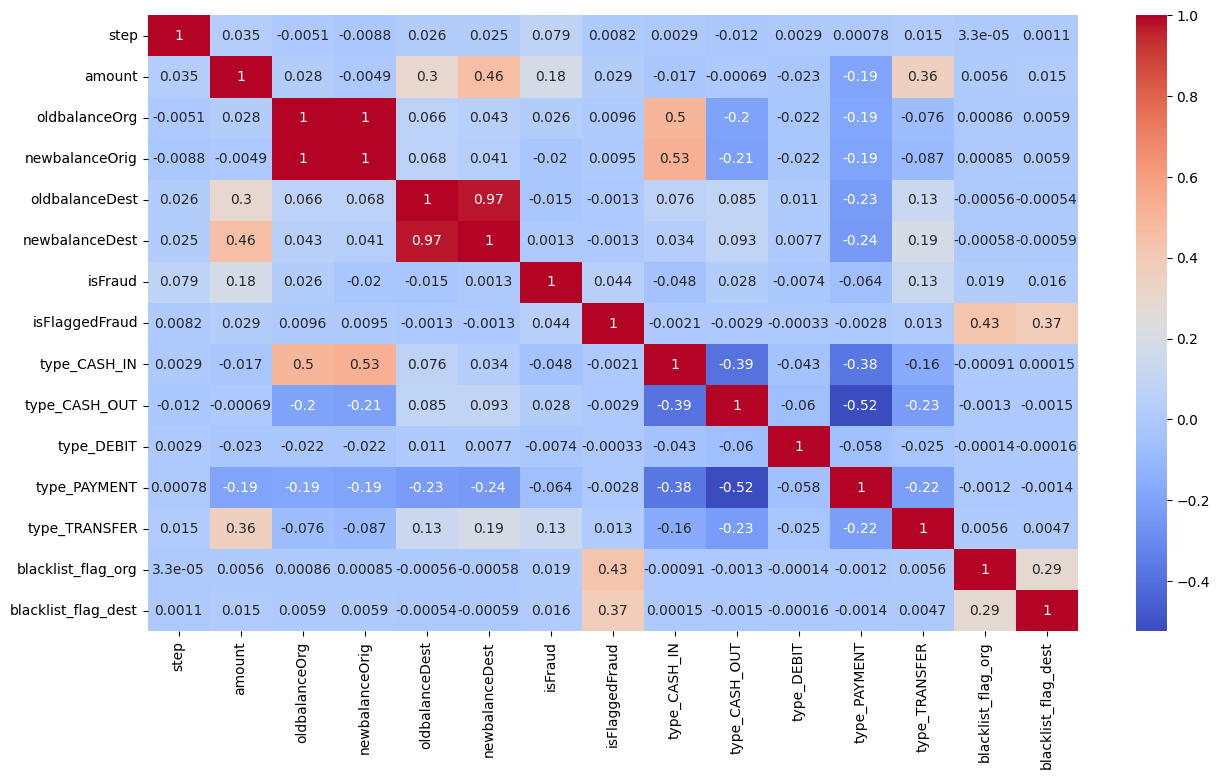

In [30]:
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

In [31]:
numerical_columns = df.select_dtypes(exclude='object').columns.to_list()
categorical_columns = df.select_dtypes(include='object').columns.to_list()
numerical_columns, categorical_columns

(['step',
  'amount',
  'oldbalanceOrg',
  'newbalanceOrig',
  'oldbalanceDest',
  'newbalanceDest',
  'isFraud',
  'isFlaggedFraud',
  'type_CASH_IN',
  'type_CASH_OUT',
  'type_DEBIT',
  'type_PAYMENT',
  'type_TRANSFER',
  'blacklist_flag_org',
  'blacklist_flag_dest'],
 ['nameOrig', 'nameDest'])

<Axes: xlabel='x', ylabel='y'>

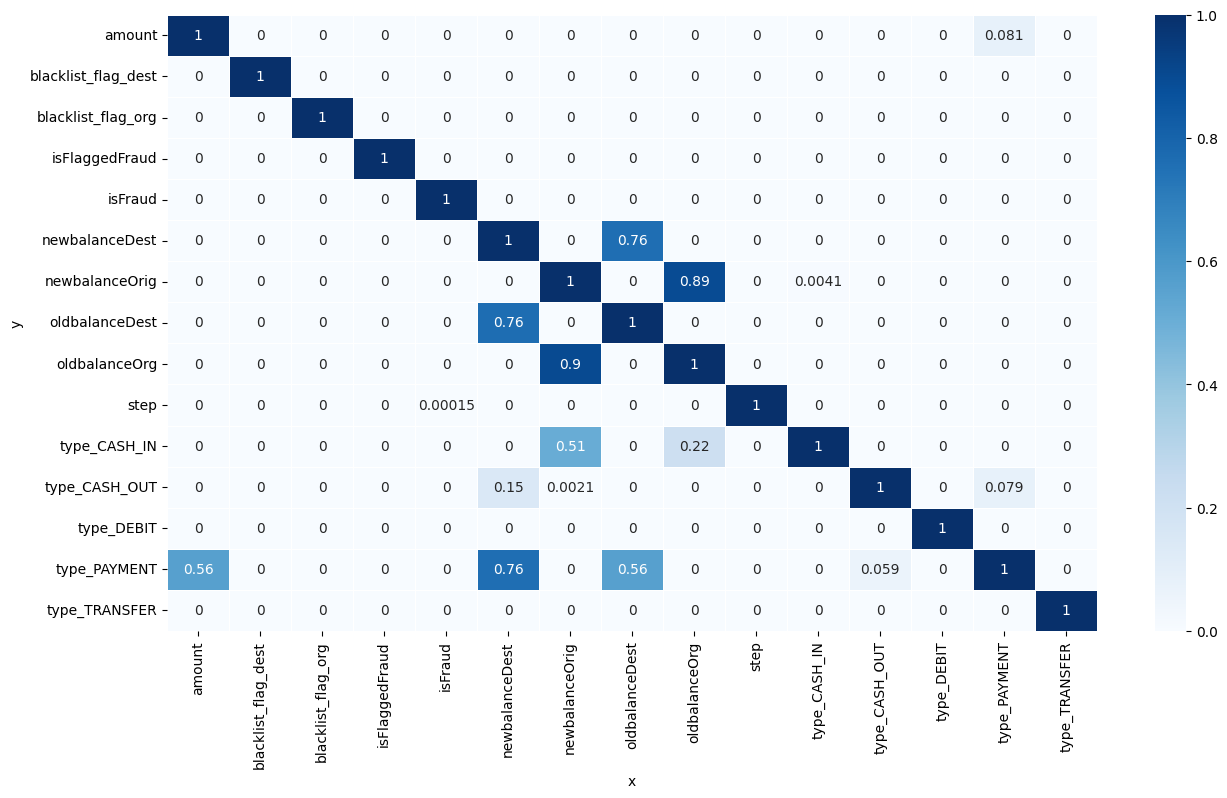

In [32]:
import ppscore as pps

dfcopy = df.copy()
dfcopy.drop(categorical_columns, axis='columns', inplace=True)
matrix_df = pps.matrix(dfcopy)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

plt.figure(figsize = (15,8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


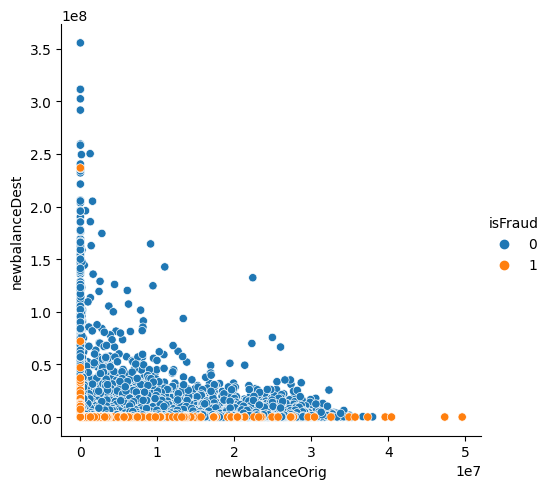

In [33]:
sns.relplot(x='newbalanceOrig', y='newbalanceDest', hue='isFraud', data=df)

In [34]:
df.columns

Index(['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'blacklist_flag_org',
       'blacklist_flag_dest'],
      dtype='object')

<Axes: xlabel='amount', ylabel='oldbalanceOrg'>

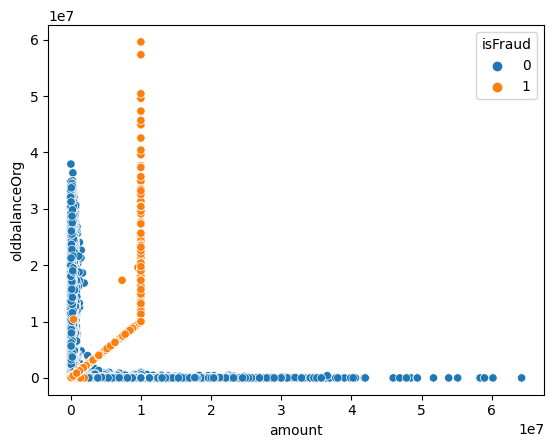

In [35]:
sns.scatterplot(df, x='amount', y='oldbalanceOrg', hue='isFraud')

<Axes: xlabel='amount', ylabel='newbalanceOrig'>

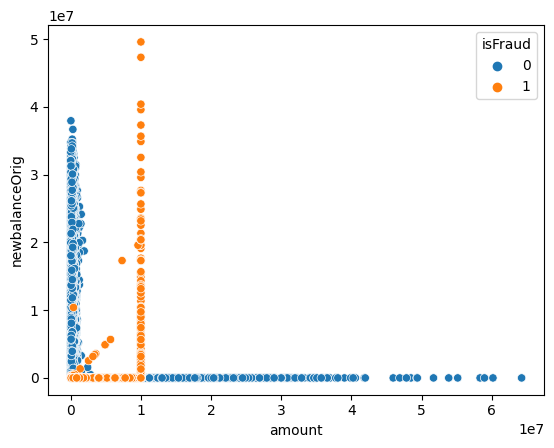

In [36]:
sns.scatterplot(df, x='amount', y='newbalanceOrig', hue='isFraud')

<Axes: xlabel='amount', ylabel='oldbalanceDest'>

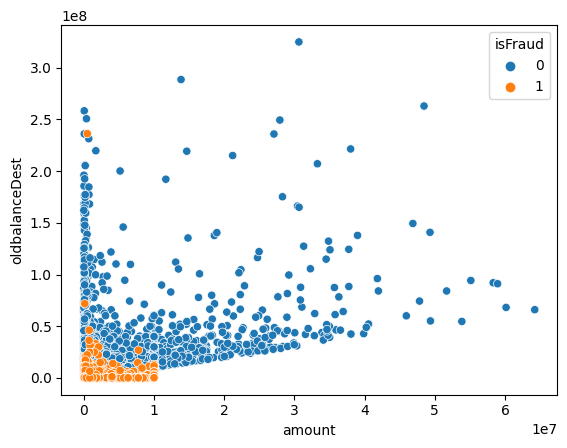

In [37]:
sns.scatterplot(df, x='amount', y='oldbalanceDest', hue='isFraud')

<Axes: xlabel='amount', ylabel='newbalanceDest'>

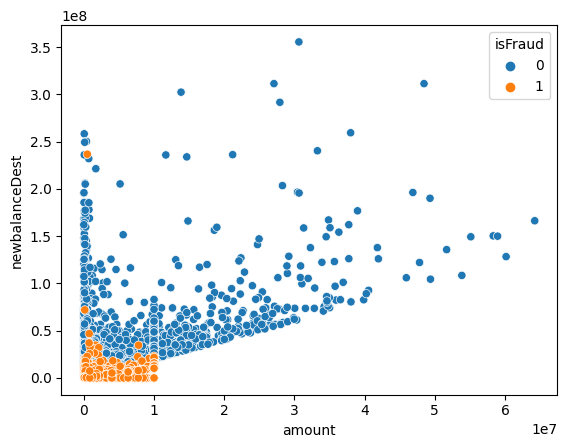

In [38]:
sns.scatterplot(df, x='amount', y='newbalanceDest', hue='isFraud')

In [44]:
df.to_csv(r'root/Dataset/Fraud_sample.csv', index = False)

: 